In [1]:
import lightkurve as lk
import gc
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

##  TOI 519 b

In [2]:
#https://arxiv.org/pdf/2011.11458.pdf
#see all data available from source
search_result = lk.search_targetpixelfile("TOI-519")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 07,2019,SPOC,120,218795833,0.0
1,TESS Sector 34,2021,SPOC,120,218795833,0.0


TESS Input Catalog (TIC 218795833)

TESS Object of Interest (TOI)

TOI 519 was observed twice, first in sector 7 and then in sector 34.

In [3]:
#download sector 7 data first
tpf_TOI519 = search_result[0].download()

X x Y x time

<AxesSubplot:title={'center':'Target ID: 218795833, Cadence: 190207'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

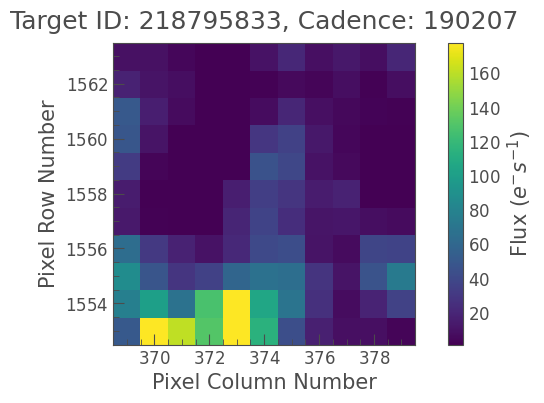

In [4]:
#plot the tpf
tpf_TOI519.plot(frame=0)

The target is in the center of the tpf but it seems the star is very faint. What is its Vmag?

In [8]:
#print the tpf header
tpf_TOI519.header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    3 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2019-02-23'         / file creation date.                            
TSTART  =    1491.625533688852 / observation start time in TJD                  
TSTOP   =    1516.086634607482 / observation stop time in TJD                   
DATE-OBS= '2019-01-08T02:59:

In [16]:
#very faint indeed!
tpf_TOI519.header['TESSMAG']

14.53299999

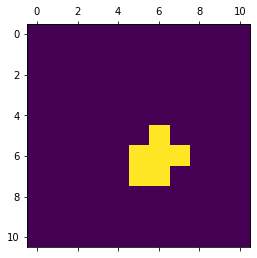

In [6]:
import matplotlib.pyplot as plt

#let's see how the pipeline mask looks like
aper_mask = tpf_TOI519.pipeline_mask
plt.matshow(aper_mask)

In [7]:
# Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
lc_TOI519 = tpf_TOI519.to_lightcurve(aperture_mask=aper_mask)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

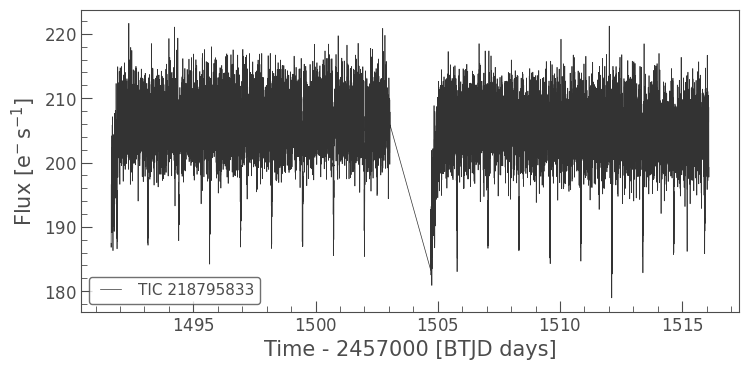

In [8]:
lc_TOI519.plot()

The raw lightcurve above looks quite flat but we can remove the remaining systematic noise. But how long should the `window_length` be so that it won't affect the transit signal?

A general rule-of-thumb is about 3 times the transit duration. But if we do not know the transit duration yet, let's experiment using different `window_lengths`.

In [9]:
#flatten the lightcurve and return the trend or baseline function
flat_TOI519, baseline = lc_TOI519.flatten(window_length=101, return_trend=True)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

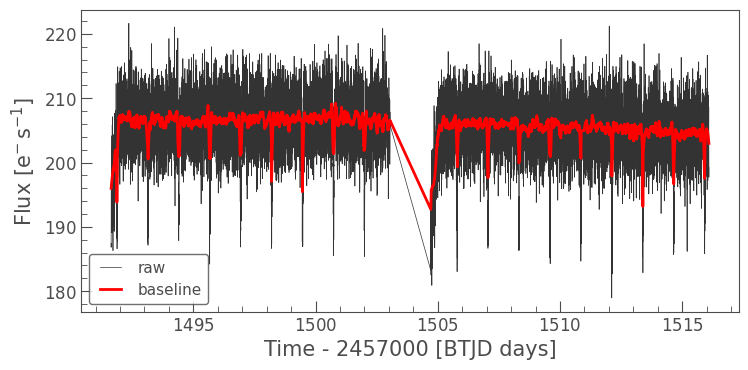

In [10]:
#plot both raw and baseline
ax = lc_TOI519.plot(label='raw')
baseline.plot(ax=ax, color='red', lw=2, label='baseline')

In [11]:
duration = 1.2332
duration

1.2332

In [12]:
import numpy as np 

#short cadence: 2 minutes
np.median(np.diff(tpf_TOI519.time))*24*60

<TimeDelta object: scale='tdb' format='jd' value=2.000036717290641>

In [13]:
wl = 501
(wl*np.median(np.diff(tpf_TOI519.time))*24)/duration

<TimeDelta object: scale='tdb' format='jd' value=13.542253153889758>

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

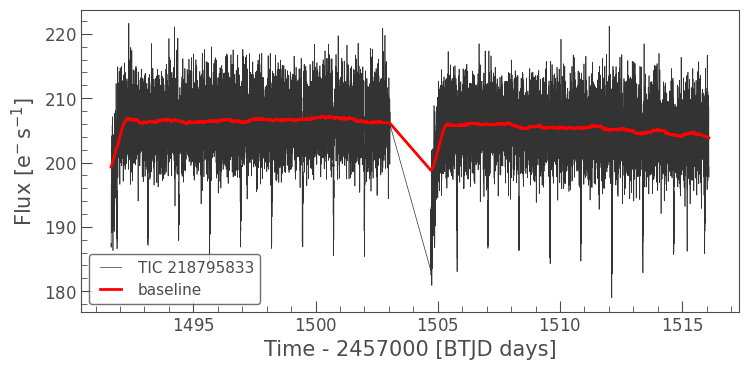

In [14]:
#window_length=101 is a bad choice because it goes through each dip, use longer window_length
flat_TOI519, baseline = lc_TOI519.flatten(window_length=501, 
                                          break_tolerance=50, 
                                          polyorder=1, 
                                          return_trend=True)
ax = lc_TOI519.plot()
baseline.plot(ax=ax, color='red', lw=2, label='baseline')

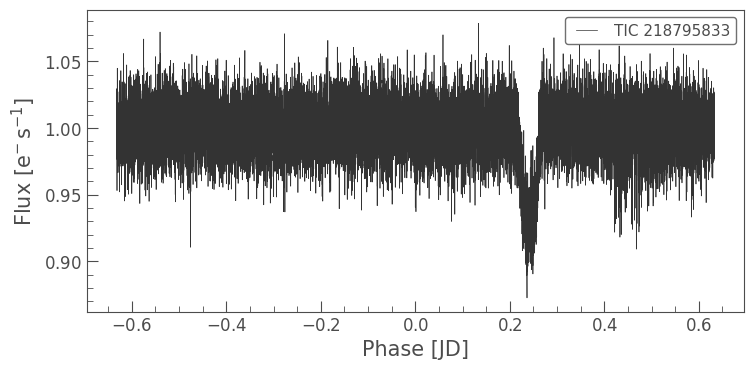

In [15]:
folded_TOI519 = flat_TOI519.fold(period=1.2652)
folded_TOI519.plot();

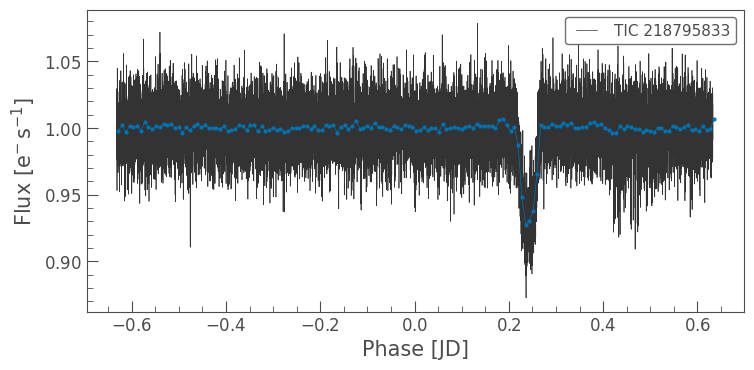

In [26]:
#plot flat lc with binned lc

ax = folded_TOI519.plot();

binned_TOI519 = folded_TOI519.bin(time_bin_size=0.008)
binned_TOI519.plot(ax=ax, marker="o");

#ax.set_xlim(-0.15, 0.35)

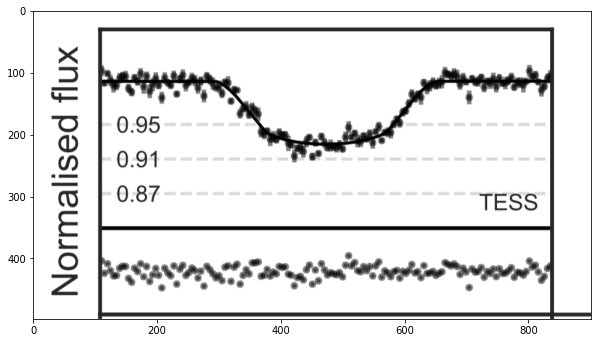

In [54]:
img = Image.open("TOI519.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()

## 55 Cancri e

In [40]:
tpf_55Cancri = lk.search_targetpixelfile("55Cancri", cadence="long")#.download()
tpf_55Cancri

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 21,2020,TESS-SPOC,1800,332064670,0.0


In [41]:
tpf_55Cancri = tpf_55Cancri.download()

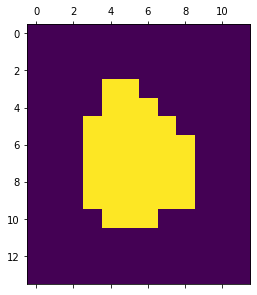

In [29]:
aper_mask = tpf_55Cancri.pipeline_mask
plt.matshow(aper_mask)

In [42]:
tpf_55Cancri.interact(aperture_mask="pipeline")

In [30]:
lc_55Cancri = tpf_55Cancri.to_lightcurve(aperture_mask=tpf_55Cancri.pipeline_mask)

In [43]:
clean_lc = lc_55Cancri.remove_outliers(sigma_lower=3, sigma_upper=5);

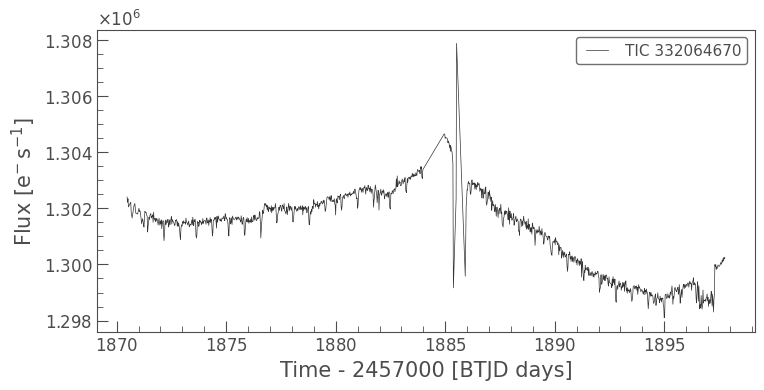

In [45]:
clean_lc.plot();

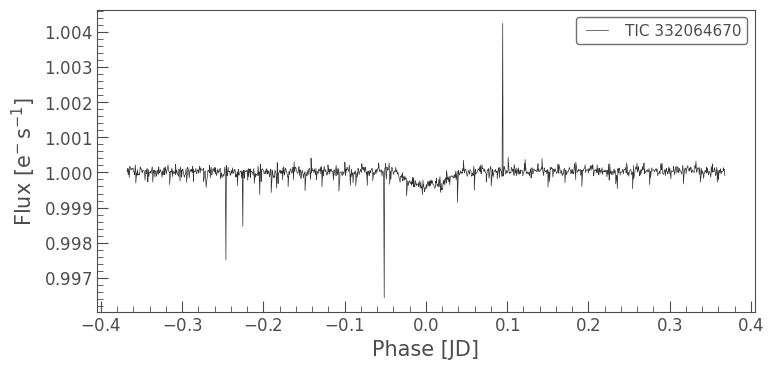

In [62]:
clean_lc.remove_nans().flatten(window_length=101).fold(period=0.7365449, epoch_time=2457063.2096- 2457000).plot();


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

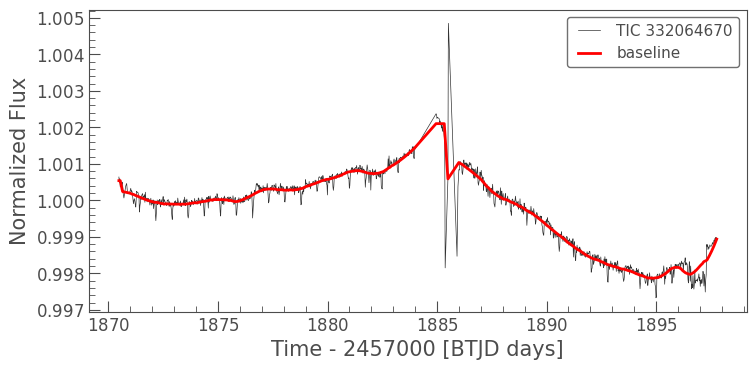

In [54]:
flat_55Cancri, baseline = clean_lc.normalize().flatten(window_length=101, 
#                                           break_tolerance=50, 
#                                           polyorder=1, 
                                          return_trend=True
                                        )
ax = clean_lc.normalize().plot()
baseline.plot(ax=ax, color='red', lw=2, label='baseline')